# <font color=blue> Battle of Neighborhoods </font>

## 1. Introduction
The [Brooklyn Public Library](https://www.bklynlibrary.org/about) system is the fifth largest public library system in the United States. It offers study and work space, literacy, out-of-school-time services, workforce development programs, digital literacy and so on. It currently has nearly 700,000 active cardholders.

In this project I want to understand the neighborhoods around those libraries. I am going to use Web scrapping to get a list of Brooklyn Public Libraries and utilize the foursquare API to explore their neighborhood venues. At last I will use the K-Means Clustering to classify those libraries according to their surrounding venues. 

## 2. Stakeholders
Speaking of libraries, you can easily relate to researchers, students and families with kids. Public libraries are also popular among freelancers. A [report](https://www1.nyc.gov/assets/mome/pdf/freelancing-ny-report-09062019.pdf) from the New York city mayors office of media and entertainment freelancers Union indicated that over 1/3 of the workforce are freelancers. 33% of them reside in Broolyn. Of course co-working spaces and cafes are popular too, but they are costly to visit on a regular basis. Public libraries on the other hand are free to use. This analysis can help people to choose their libraries in Brooklyn. It could also help city planners to learn from one of the best library system. Here I list a few scenarios where this study will help. 
1. Freelancers who want to have some nightlife after work.
2. Families who want to visit a park near the library. 
3. Students who want to go shopping together. 
4. Researchers who are interested in muesums and gallaries. 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
import requests
import csv

print('Libraries imported.')

Libraries imported.


## 3. Data

3.1  First I use [BeautifulSoup4](https://beautiful-soup-4.readthedocs.io/en/latest/) to get a list of Brooklyn Public Library branches from Wikipedia. 

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_Brooklyn_Public_Library_branches').text
soup = BeautifulSoup(source, 'lxml')
#print(soup.prettify())

In [3]:
csv_file = open('brooklyn_library.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Library', 'Address'])
for i in np.arange(0,60):
    Library=soup.find_all('td')[1+5*i].text  
    Address=soup.find_all('td')[3+5*i].text
    print(Library)
    print(Address)  
    print('')
    csv_writer.writerow([Library, Address])
csv_file.close()

Arlington Library[1]

203 Arlington Avenue


Bay Ridge Library[2]

7223 Ridge Boulevard


Bedford Library[3]

496 Franklin Avenue


Borough Park Library

1265 43rd Street


Brighton Beach Library

16 Brighton First Road


Brooklyn Heights Library[4]

280 Cadman Plaza West


Brower Park Library

725 St. Marks Avenue


Brownsville Library

61 Glenmore Avenue


Bushwick Library

340 Bushwick Avenue


Business & Career Library[5]

280 Cadman Plaza West


Canarsie Library

1580 Rockaway Parkway


Carroll Gardens Library[6]

396 Clinton Street


Central Library

10 Grand Army Plaza


Clarendon Library

2035 Nostrand Avenue


Clinton Hill Library[7]

380 Washington Avenue


Coney Island Library[8]

1901 Mermaid Avenue


Cortelyou Library

1305 Cortelyou Road


Crown Heights Library

560 New York Avenue


Cypress Hills Library

1197 Sutter Avenue


DeKalb Library

790 Bushwick Avenue


Dyker Library

8202 13th Avenue


East Flatbush Library

9612 Church Avenue


Eastern Parkway Library

1044 E

In [4]:
Libraries_data=pd.read_csv('brooklyn_library.csv', header=[0])

Libraries_data['Library'] = Libraries_data['Library'].map(lambda x: x.rstrip('\r\n[1][2][3][4][5][6][7][8]'))
Libraries_data['Address'] = Libraries_data['Address'].map(lambda x: x.rstrip('\r\n'))


In [5]:
Libraries_data.head()

,Library,Address
0,Arlington Library,203 Arlington Avenue
1,Bay Ridge Library,7223 Ridge Boulevard
2,Bedford Library,496 Franklin Avenue
3,Borough Park Library,1265 43rd Street
4,Brighton Beach Library,16 Brighton First Road


## Now let's get the coordinates of these libraries

Nominatim map is a free way to get address infomation. For instance, Nominatim recognize 4th St, but not Fourth Street. You will need to manually change that.  You can also you Google map3, a paid service which can detect address better. In my case I had to change the format of one address. 

In [6]:
#Nominatim map can be unstable and return the wrong address. 
#You might need to change some address format manually. 
Libraries_data.iloc[44,1]='25 4th Ave'

geolocator = Nominatim(user_agent='manhattan_explore', format_string='%s, Brooklyn')
col1, col2 = [],[]
for row in np.arange(len(Libraries_data)):
    #print(Libraries_data.iloc[row,0])
    # try address, if Nominatim couldn't find it due to format problem, then try using the librarie's name directly
    try:
        location= geolocator.geocode(Libraries_data.iloc[row,1])
        col1.append(location.latitude)
    except:
        location= geolocator.geocode(Libraries_data.iloc[row,0])
        col1.append(location.latitude)     

    col2.append(location.longitude)

In [7]:
Libraries_data['Latitude']=col1
Libraries_data['Longitude']=col2

In [8]:
#Libraries_data.drop(['Address'],axis=1, inplace=True)
Libraries_data.to_csv(r'Libraries_data.csv', index=False, header=True)

In [9]:
Libraries_data=pd.read_csv('Libraries_data.csv')
Libraries_data.head()

,Library,Address,Latitude,Longitude
0,Arlington Library,203 Arlington Avenue,40.680687,-73.887232
1,Bay Ridge Library,7223 Ridge Boulevard,40.633627,-74.029531
2,Bedford Library,496 Franklin Avenue,40.681797,-73.956169
3,Borough Park Library,1265 43rd Street,40.638878,-73.989010
4,Brighton Beach Library,16 Brighton First Road,40.579644,-73.961111


#### 3.2 Put the library locations into a map

In [10]:
address = 'Brooklyn, NYC'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [11]:
map_library = folium.Map(location=[latitude, longitude], zoom_start=11.1)
Libraries_data = pd.read_csv('Libraries_data.csv', header=[0])
# add markers to map
for lat, lng, label in zip(Libraries_data['Latitude'], Libraries_data['Longitude'], Libraries_data['Library']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_library)  
    
map_library

#### Utilizing the Foursquare API to explore the neighborhoods and segment them.
Let's get the venues in high level categories near 500 meters of each library. That's about 10 minute walking distance. 

In [12]:
CLIENT_ID = 'LMRMAFHIPCXERLS0TMW1HGBMJTSF4FNO4H1KVHQUM1CQ1H2L' # your Foursquare ID
CLIENT_SECRET = 'EZHAJVX0MN3ZAHBDIAAD1EJAAGGGQCUXMDOOEICI5JKY52GE' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius=500

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['icon']['prefix'].split('/')[-2]) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Library', 
                  'Library Latitude', 
                  'Library Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

In [14]:
# type your answer here
library_venues = getNearbyVenues(names=Libraries_data['Library'],
                                   latitudes=Libraries_data['Latitude'],
                                   longitudes=Libraries_data['Longitude'],
                                  radius=500)


In [15]:
library_venues.to_csv(r'libraries_venues.csv', index=False, header=True)

In [16]:
print(library_venues.shape)
library_venues.head()

(2425, 7)


,Library,Library Latitude,Library Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arlington Library,40.680687,-73.887232,Highland Park,40.682002,-73.889173,parks_outdoors
1,Arlington Library,40.680687,-73.887232,Caterina Pizza,40.680558,-73.882778,food
2,Arlington Library,40.680687,-73.887232,Rico Chimi Cafeteria,40.677456,-73.886389,food
3,Arlington Library,40.680687,-73.887232,Little Caesars Pizza,40.678476,-73.888577,food
4,Arlington Library,40.680687,-73.887232,North Brooklyn YMCA,40.682066,-73.889165,building


#### Let's check out how many venues were found for each library

In [17]:
library_venues= pd.read_csv('libraries_venues.csv')
print('Number of venues found in each Library:')
library_venues['Library'].value_counts()



Number of venues found in each Library:


Business & Career Library    100
Leonard Library              100
Brooklyn Heights Library     100
Pacific Library              100
Carroll Gardens Library       87
Flatbush Library              81
Bedford Library               75
Greenpoint Library            71
Washington Irving Library     71
Bay Ridge Library             70
Park Slope Library            67
Clarendon Library             60
Fort Hamilton Library         56
Marcy Library                 54
Macon Library                 51
Central Library               48
Clinton Hill Library          48
Brighton Beach Library        47
Sheepshead Bay Library        44
Bushwick Library              44
Coney Island Library          44
Flatlands Library             43
Windsor Terrace Library       42
Eastern Parkway Library       41
DeKalb Library                41
Red Hook Library              40
Homecrest Library             40
Brower Park Library           38
Midwood Library               37
McKinley Park Library         36
Cortelyou 

In [18]:
print('There are {} uniques categories.'.format(len(library_venues['Venue Category'].unique())))

There are 8 uniques categories.


## Analyzing each Library
Use one hot encoding first, then get the number of each type of the venues. 

In [19]:
# one hot encoding
library_onehot = pd.get_dummies(library_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood names  back to dataframe
library_onehot.insert(0,'Library', library_venues['Library']) 

library_onehot.head()

,Library,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,Arlington Library,0,0,0,0,0,1,0,0
1,Arlington Library,0,0,0,1,0,0,0,0
2,Arlington Library,0,0,0,1,0,0,0,0
3,Arlington Library,0,0,0,1,0,0,0,0
4,Arlington Library,0,1,0,0,0,0,0,0


In [20]:
library_grouped0 = library_onehot.groupby('Library').sum().reset_index()
library_grouped0.head()

,Library,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,Arlington Library,1,3,0,9,0,2,7,2
1,Bay Ridge Library,0,2,1,52,9,0,6,0
2,Bedford Library,2,7,1,25,18,1,21,0
3,Borough Park Library,0,1,0,9,0,0,7,1
4,Brighton Beach Library,2,1,1,23,2,4,14,0


Now let's visualize this with the violin plot. Violin plot is a combination of box plot and kernel density plot. Note our data is non-negative. The violin range is restricted to be within the range of the actually data. 

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


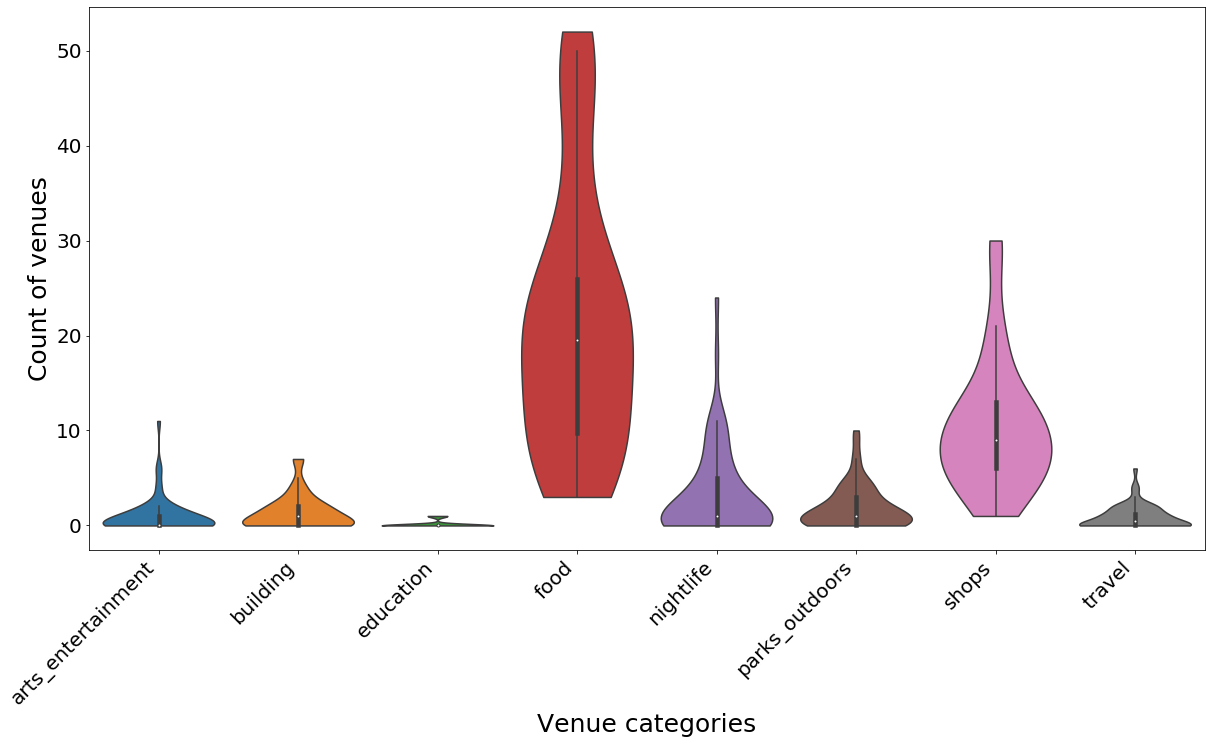

In [22]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')

ax = sns.violinplot(data = library_grouped0, scale='count',cut=0)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue categories', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

As we can see from the graph, the most popular venues near the Brooklyn public libraries are food and shops. There are barely any education and event venue, therefore I drop them. Then I also rank the venues by their absolute counts for each library. This information will be added to the map labels later.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 7
columns = ['Library']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
Library_venues_sorted = pd.DataFrame(columns=columns)
Library_venues_sorted['Library'] = library_grouped0['Library']


for ind in np.arange(library_grouped0.shape[0]):
    Library_venues_sorted.iloc[ind, 1:] = return_most_common_venues(library_grouped0.iloc[ind,:],num_top_venues)
    
Library_venues_sorted.head()   

,Library,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Arlington Library,food,shops,building,travel,parks_outdoors,arts_entertainment,nightlife
1,Bay Ridge Library,food,nightlife,shops,building,education,travel,parks_outdoors
2,Bedford Library,food,shops,nightlife,building,arts_entertainment,parks_outdoors,education
3,Borough Park Library,food,shops,travel,building,parks_outdoors,nightlife,education
4,Brighton Beach Library,food,shops,parks_outdoors,nightlife,arts_entertainment,education,building


## Preprocessing
Before using K-means clustering, the data are normalized with minmax scaler. The range for each variable will become 0 to 1 and count value becomes relative count. Let me use an example to illustrate what I mean by relative count. The normalized counts of food for Arlington Library and Bay Ridge Library are 0.14 and 0.88 respectively. It tells us that Arlington Library has fewer food venues nearby than Bay Ridge Library. I also know the normalized count of building for Arlington library is 0.43. But I cannot say that there are more building venues than food venues near Arlington. Normalization makes sure that we don't impose any weight on each venue before forming clusters. If you want, you can always refer to the actual counts after clustering. 

In [25]:
library_grouped0.drop(['education'], axis=1, inplace=True)
from sklearn.preprocessing import MinMaxScaler

X = library_grouped0.values[:,1:]
cluster_dataset = MinMaxScaler().fit_transform(X)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [26]:
#library_grouped_clustering = pd.DataFrame(cluster_dataset)
library_grouped = library_grouped0.copy()
library_grouped.iloc[:,1:]=cluster_dataset
library_grouped.head()

,Library,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel
0,Arlington Library,0.090909,0.428571,0.122449,0.000000,0.2,0.206897,0.333333
1,Bay Ridge Library,0.000000,0.285714,1.000000,0.375000,0.0,0.172414,0.000000
2,Bedford Library,0.181818,1.000000,0.448980,0.750000,0.1,0.689655,0.000000
3,Borough Park Library,0.000000,0.142857,0.122449,0.000000,0.0,0.206897,0.166667
4,Brighton Beach Library,0.181818,0.142857,0.408163,0.083333,0.4,0.448276,0.000000


Let's visualize this again, and you will see each feature is between 0 and 1 now.

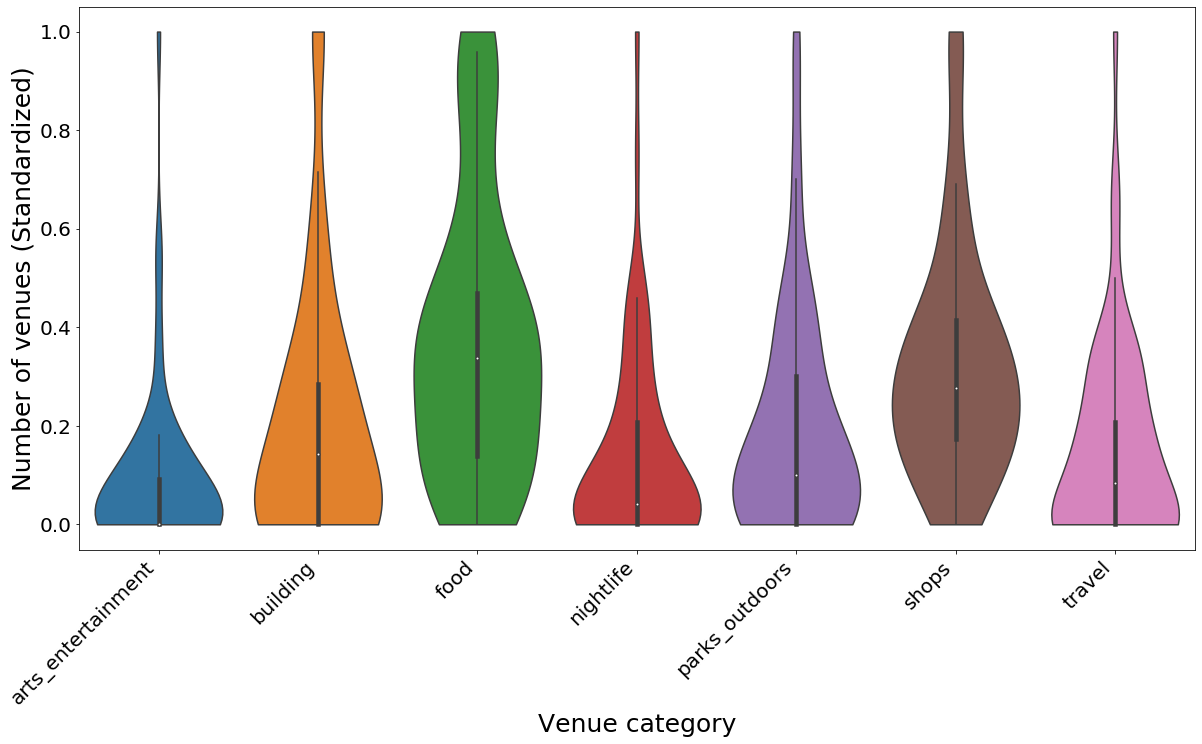

In [27]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.violinplot(data = library_grouped, scale='count', cut=0)
ax.set_ylabel('Number of venues (Standardized)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

## K-Means Clustering
Now the data is ready for K-Means clustering. After varying the the number of clusters from 2 to 5, I find k=4 is the best. 
k = 2 divides the libraries located innner and outter city.
k = 3 adds a few outliers.

In [28]:
kclusters = 4

library_grouped_clustering = library_grouped.drop(['Library'],1)

kmeans = KMeans(n_clusters=kclusters, random_state= 10).fit(library_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 0, 3, 2, 0, 3, 2, 2, 0, 3, 2, 3, 0, 0, 0, 1, 2, 2, 2, 2, 2, 1,
       2, 3, 2, 0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 3, 0, 2, 0, 0, 2, 2, 2, 2,
       3, 2, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 0, 2, 0])

In [29]:
library_cluster=library_grouped.copy()
library_cluster['Cluster Labels']= kmeans.labels_
library_cluster[['Latitude','Longitude']]=Libraries_data[['Latitude','Longitude']]
pd.DataFrame(library_cluster).head()

,Library,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel,Cluster Labels,Latitude,Longitude
0,Arlington Library,0.090909,0.428571,0.122449,0.000000,0.2,0.206897,0.333333,1,40.680687,-73.887232
1,Bay Ridge Library,0.000000,0.285714,1.000000,0.375000,0.0,0.172414,0.000000,0,40.633627,-74.029531
2,Bedford Library,0.181818,1.000000,0.448980,0.750000,0.1,0.689655,0.000000,3,40.681797,-73.956169
3,Borough Park Library,0.000000,0.142857,0.122449,0.000000,0.0,0.206897,0.166667,2,40.638878,-73.989010
4,Brighton Beach Library,0.181818,0.142857,0.408163,0.083333,0.4,0.448276,0.000000,0,40.579644,-73.961111


library_cluster=library_grouped0.copy()
library_cluster['Cluster Labels']= kmeans.labels_
library_cluster[['Latitude','Longitude']]=Libraries_data[['Latitude','Longitude']]
pd.DataFrame(library_cluster).head()

Let us exam each cluster now. Since each cluster don't contain a lot of data, the Gaussian kernel density estimate can be more misleading than informative. We are better off just to look at boxplots. 

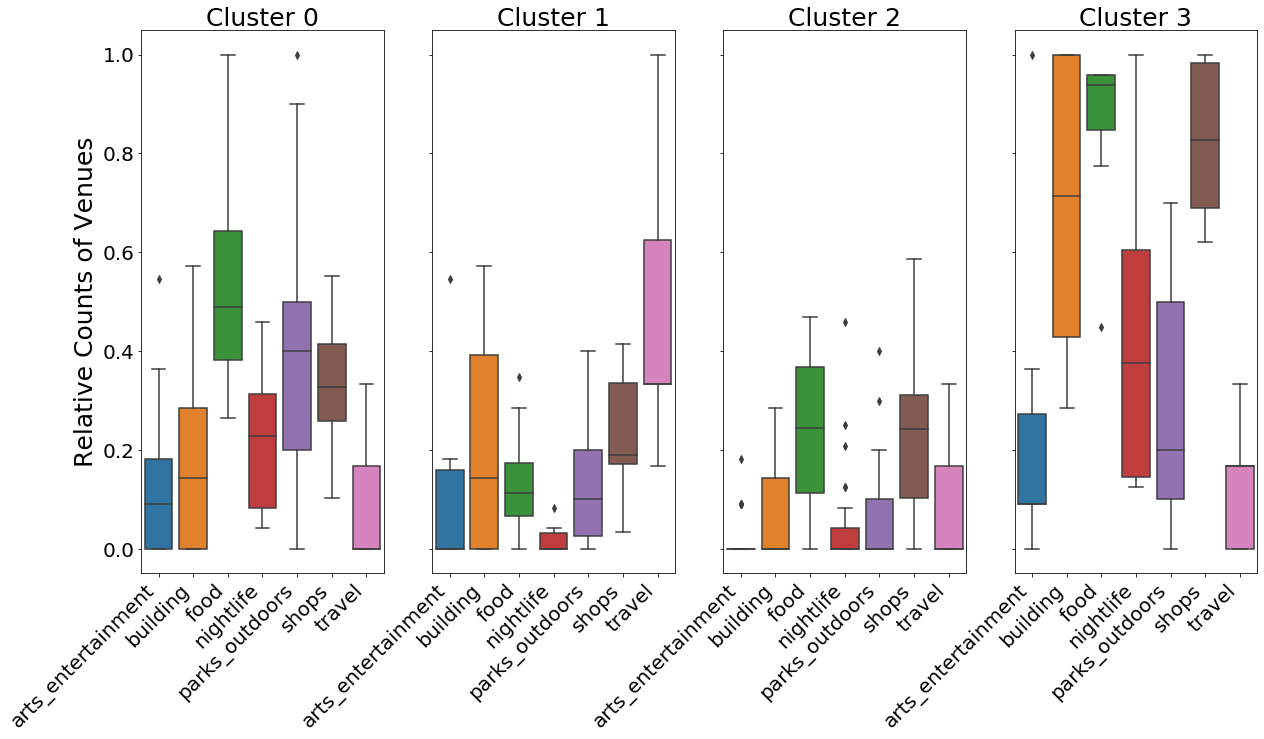

In [30]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Relative Counts of Venues', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
   # axes[k].set_ylim(0.0,1.5)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation=45, ha='right')
    sns.boxplot(data = library_cluster[library_cluster['Cluster Labels'] == k].iloc[:,1:8], ax=axes[k])
plt.show()

Since some categories don't contain a lot of data, the Gaussian kernel density estimate is be more misleading than informative. We are better off just to look at boxplots than violin plots.

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colors=['green','orange','blue','red']

# add markers to the map
markers_colors = []
for ind, lat, lon, poi, cluster in zip(library_cluster.index,
                                  library_cluster['Latitude'], 
                                  library_cluster['Longitude'], 
                                  library_cluster['Library'], 
                                  library_cluster['Cluster Labels']):
 #   label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) +"\n"
 #                        +Library_venues_sorted.iloc[0,1] <br>
 #                        Library_venues_sorted.iloc[0,1],

 #                        parse_html=True)
    label = '{} - Cluster {}<br> Top 2 venues: {}, {}<br> Bottom 2 venues: {}, {}'.format(
            poi,
            cluster,
             Library_venues_sorted.iloc[ind,1],
             Library_venues_sorted.iloc[ind,2],
             Library_venues_sorted.iloc[ind,-2],
             Library_venues_sorted.iloc[ind,-1],
        parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [32]:
map_clusters.save('BPLmap.html')


## Analyzing Each Cluster

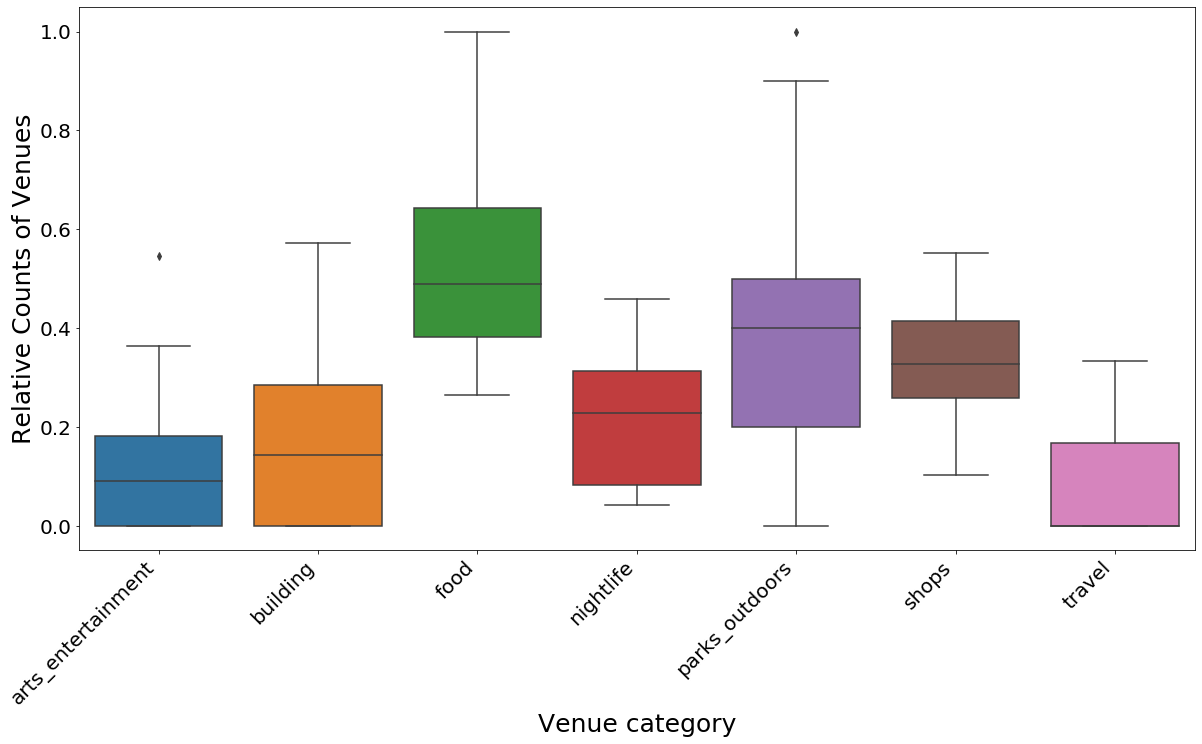

In [33]:
cluster0=library_cluster[library_cluster['Cluster Labels']==0]
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster0.iloc[:,:-3])
#ax = sns.boxplot(data = cluster0)
ax.set_ylabel('Relative Counts of Venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()


#### Cluster 0
We can see that Cluster 0 has the highest relative count in travel and food.  It doesn't have much nightlife nearby. Libraries in cluster 0 are located in the Northeast and South of Brooklyn.

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for ind, lat, lon, poi, cluster in zip(cluster0.index,
                                  cluster0['Latitude'], 
                                  cluster0['Longitude'], 
                                  cluster0['Library'], 
                                  cluster0['Cluster Labels']):
 #   label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) +"\n"
 #                        +Library_venues_sorted.iloc[0,1] <br>
 #                        Library_venues_sorted.iloc[0,1],

 #                        parse_html=True)
    label = '{} - Cluster {}<br> Top 2 venues: {}, {}<br> Bottom 2 venues: {}, {}'.format(
            poi,
            cluster,
             Library_venues_sorted.iloc[ind,1],
             Library_venues_sorted.iloc[ind,2],
             Library_venues_sorted.iloc[ind,-2],
             Library_venues_sorted.iloc[ind,-1],
        parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1
Cluster 1 offers all kinds of venues You will see more food and shops in Cluster 1 than in other Clusters. Plus you can also find arts and entertainment in Cluster 1.
Libraries in Cluster 1 are mostly in the Northwest.

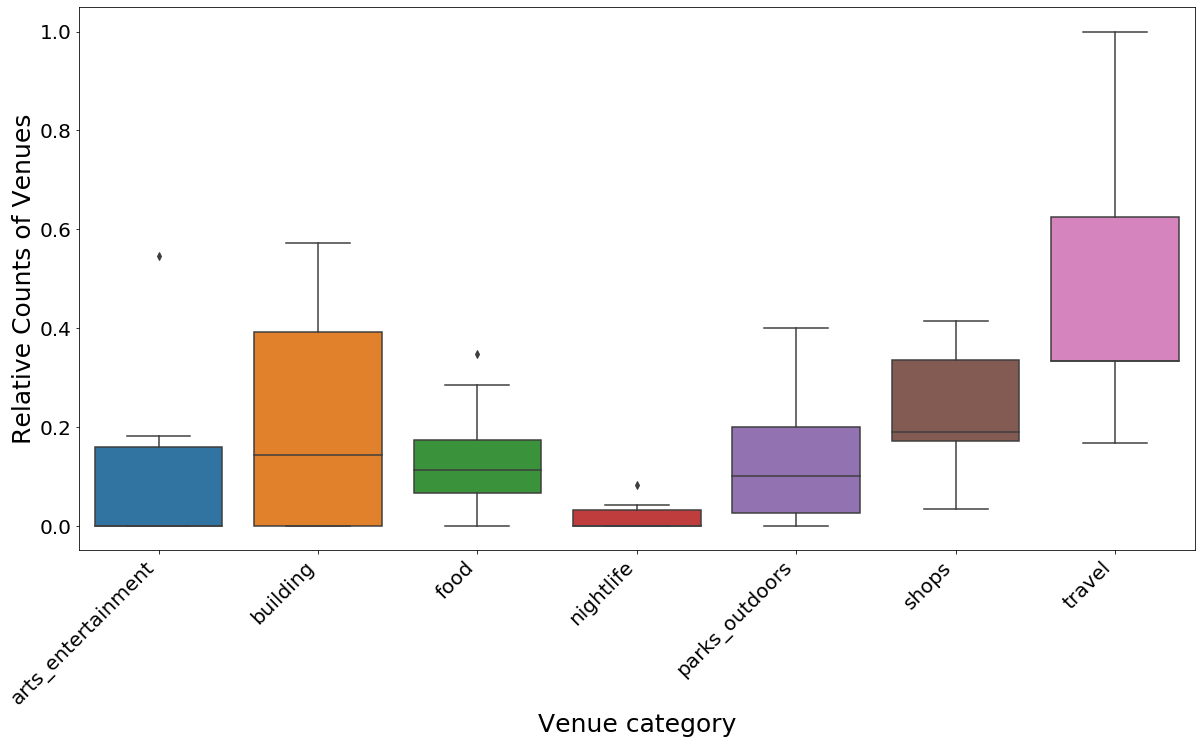

In [35]:
cluster1=library_cluster[library_cluster['Cluster Labels']==1]
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster1.iloc[:,:-3])
ax.set_ylabel('Relative Counts of Venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()


In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for ind, lat, lon, poi, cluster in zip(cluster1.index,
                                  cluster1['Latitude'], 
                                  cluster1['Longitude'], 
                                  cluster1['Library'], 
                                  cluster1['Cluster Labels']):
 #   label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) +"\n"
 #                        +Library_venues_sorted.iloc[0,1] <br>
 #                        Library_venues_sorted.iloc[0,1],

 #                        parse_html=True)
    label = '{} - Cluster {}<br> Top 2 venues: {}, {}<br> Bottom 2 venues: {}, {}'.format(
            poi,
            cluster,
             Library_venues_sorted.iloc[ind,1],
             Library_venues_sorted.iloc[ind,2],
             Library_venues_sorted.iloc[ind,-2],
             Library_venues_sorted.iloc[ind,-1],
        parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 2
Cluster 2's top venues are food and parks and outdoors. It barely has any travel, which means they are likely far from public transportation. From the location map, we can notice that these libraries are mostly located to the west side of Brooklyn.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

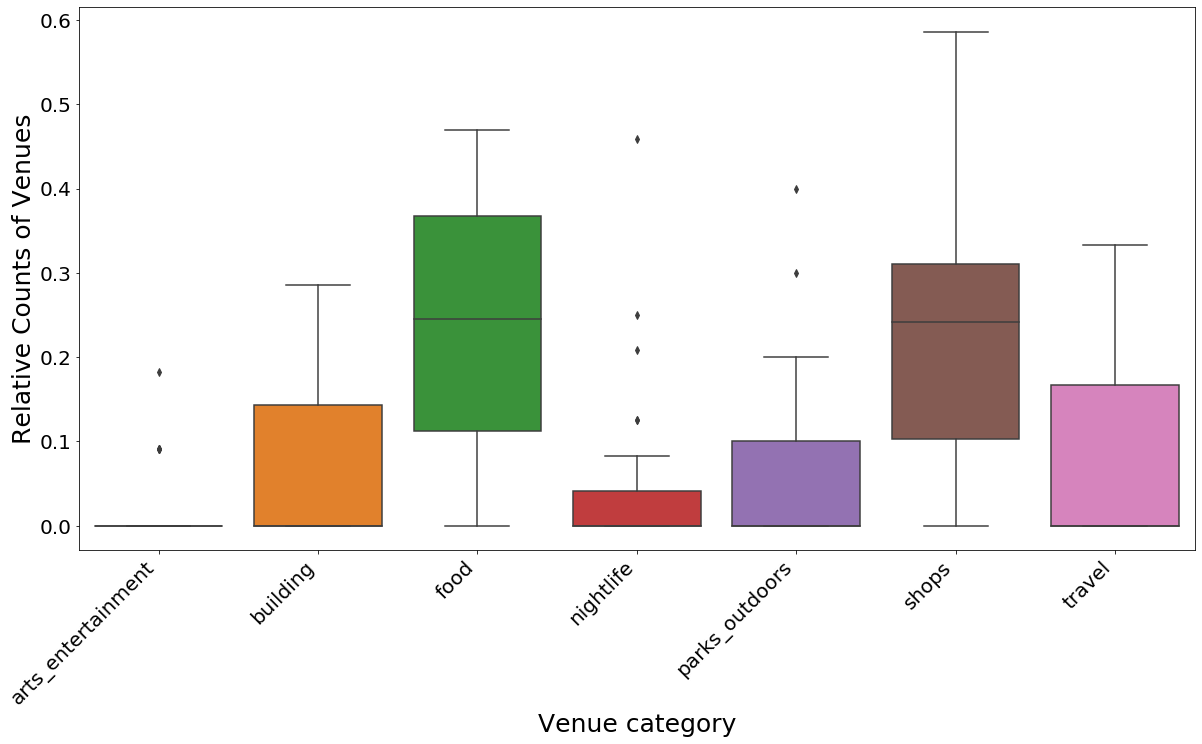

In [37]:
cluster2=library_cluster[library_cluster['Cluster Labels']==2]

plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster2.iloc[:,:-3])
ax.set_ylabel('Relative Counts of Venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

#plt.show()


In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for ind, lat, lon, poi, cluster in zip(cluster2.index,
                                  cluster2['Latitude'], 
                                  cluster2['Longitude'], 
                                  cluster2['Library'], 
                                  cluster2['Cluster Labels']):
 #   label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) +"\n"
 #                        +Library_venues_sorted.iloc[0,1] <br>
 #                        Library_venues_sorted.iloc[0,1],

 #                        parse_html=True)
    label = '{} - Cluster {}<br> Top 2 venues: {}, {}<br> Bottom 2 venues: {}, {}'.format(
            poi,
            cluster,
             Library_venues_sorted.iloc[ind,1],
             Library_venues_sorted.iloc[ind,2],
             Library_venues_sorted.iloc[ind,-2],
             Library_venues_sorted.iloc[ind,-1],
        parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 3
Top venues for Cluster 3 are food and shops. There are only a few art and entertainment near Cluster 3. Below shows their locations. You can see they are in the South and Northeast of Brooklyn. A large number of Brooklyn public libraries fall into Cluster 3.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

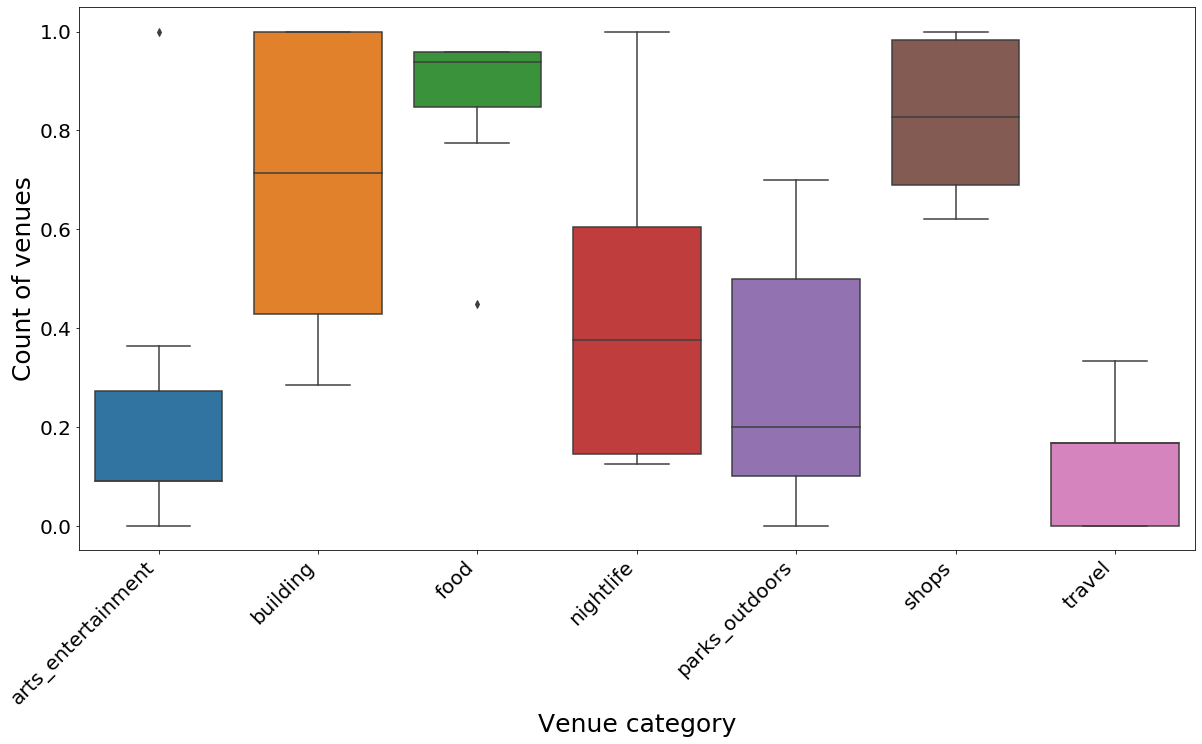

In [39]:
cluster3=library_cluster[library_cluster['Cluster Labels']==3]

plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster3.iloc[:,:-3])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

#plt.show()

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for ind, lat, lon, poi, cluster in zip(cluster3.index,
                                  cluster3['Latitude'], 
                                  cluster3['Longitude'], 
                                  cluster3['Library'], 
                                  cluster3['Cluster Labels']):
 #   label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) +"\n"
 #                        +Library_venues_sorted.iloc[0,1] <br>
 #                        Library_venues_sorted.iloc[0,1],

 #                        parse_html=True)
    label = '{} - Cluster {}<br> Top 2 venues: {}, {}<br> Bottom 2 venues: {}, {}'.format(
            poi,
            cluster,
             Library_venues_sorted.iloc[ind,1],
             Library_venues_sorted.iloc[ind,2],
             Library_venues_sorted.iloc[ind,-2],
             Library_venues_sorted.iloc[ind,-1],
        parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclution
I analyzed the segmentation of Brooklyn Public libraries. The location data is obtained by Web Scrapping from Wikipedia. And the venues data is obtained from Foursquare API. Then I use K-means clustering to segment these libraries according to the venues within 500 meters. Violinplots, boxplot and leaflet maps are provided for illustration. 
These locations offer easy access to food and shops. Then I analyzed the relative venue counts. You will find more food, shops and night life in Cluster 1, more parks and outdoors in Cluster 2 and more travel in Cluster 0. Cluster 1 and 3 contain the largest number of libraries. Of course people will consider distance when they choose a library. There are also people who are more interested in exploring  libraries at different locations. This will help you to find your favorite spot. It will also help city planner to learn from one of the biggest library system in the United States.